# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [1]:
%run -i 'cosim_import.py'

1.7.2.post286.dev0+g7813f76b
2.9.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [2]:
caseH = 18
%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=434.64 MWh
Online 14481, Q=361.83 MWh, SoC=0.7687
Power(MW): Pt=-39.9433, Pc=-39.9433, Pd=-0.0
Ctrl: 0=7778; 1=6703; 
EVA: Load A from Aest.csv.
Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.2881 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.1244 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0657 seconds.


## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


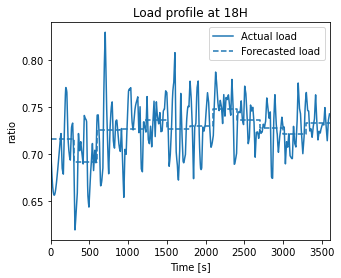

In [3]:
%run -i 'cosim_loadsyn.py'

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [4]:
%run -i 'cosim_setup_dispatch.py'
dc_comp.round(4)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1331 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.917108301
2: |F(x)| = 0.1313043343
3: |F(x)| = 0.0003572409148
4: |F(x)| = 4.286928146e-09
Converged in 5 iterations in 0.0172 seconds.
Power flow results are consistent. Conversion is successful.


Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0092 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.917108301
2: |F(x)| = 0.1313043343
3: |F(x)| = 0.0003572409148
4: |F(x)| = 4.286928146e-09
Converged in 5 iterations in 0.0105 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4910.307


pp cost=2224.8754288341006, gb cost=4910.307428177317


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,1002.8172,90.1720,15.9217,1.0,1002.8172
1,646.0000,310.9533,1.9535,1.0,646.0000
2,290.0000,148.8141,-1.1572,1.0,290.0000
3,652.0000,129.6577,6.9360,1.0,652.0000
4,508.0000,145.0387,5.1048,1.0,508.0000
5,668.5448,225.0957,6.4636,1.0,668.5448
6,232.0000,60.4667,3.2560,1.0,232.0000
7,564.0000,-26.0077,13.4712,1.0,564.0000
8,865.0000,115.2992,15.9236,1.0,865.0000
9,-39.9433,0.0000,15.9236,1.0,-39.9433


## Prepare

### Make link table

In [5]:
%run -i 'cosim_linktable.py'
ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [6]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 1.0, 1.0, 0.12

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Check convergence

In [7]:
%run -i 'cosim_bmain.py'

RTED removed: ['rampu', 'rampd']


RTED not solved:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
They run into: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Loop

In [8]:
%run -i 'cosim_main.py'

RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4557.682
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0111 seconds.
0: |F(x)| = 7.81138418
1: |F(x)| = 3.738480939
2: |F(x)| = 0.2490925162
3: |F(x)| = 0.002028931129
4: |F(x)| = 9.456904593e-08
Converged in 5 iterations in 0.0132 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for 

Simulation to t=124.00 sec completed in 0.0925 seconds.
Simulation to t=125.00 sec completed in 0.0782 seconds.
Simulation to t=126.00 sec completed in 0.0785 seconds.
Simulation to t=127.00 sec completed in 0.0773 seconds.
Simulation to t=128.00 sec completed in 0.0954 seconds.
Simulation to t=129.00 sec completed in 0.0815 seconds.
Simulation to t=130.00 sec completed in 0.0809 seconds.
Simulation to t=131.00 sec completed in 0.0771 seconds.
Simulation to t=132.00 sec completed in 0.0951 seconds.
Simulation to t=133.00 sec completed in 0.0801 seconds.
Simulation to t=134.00 sec completed in 0.0795 seconds.
Simulation to t=135.00 sec completed in 0.0764 seconds.
Simulation to t=136.00 sec completed in 0.1246 seconds.
Simulation to t=137.00 sec completed in 0.0989 seconds.
Simulation to t=138.00 sec completed in 0.0881 seconds.
Simulation to t=139.00 sec completed in 0.0935 seconds.
Simulation to t=140.00 sec completed in 0.1105 seconds.
Simulation to t=141.00 sec completed in 0.1022 s

Simulation to t=271.00 sec completed in 0.0868 seconds.
Simulation to t=272.00 sec completed in 0.1081 seconds.
Simulation to t=273.00 sec completed in 0.1011 seconds.
Simulation to t=274.00 sec completed in 0.1016 seconds.
Simulation to t=275.00 sec completed in 0.0927 seconds.
Simulation to t=276.00 sec completed in 0.1000 seconds.
Simulation to t=277.00 sec completed in 0.0966 seconds.
Simulation to t=278.00 sec completed in 0.0906 seconds.
Simulation to t=279.00 sec completed in 0.0776 seconds.
Simulation to t=280.00 sec completed in 0.0986 seconds.
Simulation to t=281.00 sec completed in 0.1062 seconds.
Simulation to t=282.00 sec completed in 0.1076 seconds.
Simulation to t=283.00 sec completed in 0.0722 seconds.
Simulation to t=284.00 sec completed in 0.0936 seconds.
Simulation to t=285.00 sec completed in 0.0793 seconds.
Simulation to t=286.00 sec completed in 0.0952 seconds.
Simulation to t=287.00 sec completed in 0.1063 seconds.
Simulation to t=288.00 sec completed in 0.0998 s

Simulation to t=417.00 sec completed in 0.1017 seconds.
Simulation to t=418.00 sec completed in 0.1039 seconds.
Simulation to t=419.00 sec completed in 0.0883 seconds.
Simulation to t=420.00 sec completed in 0.1132 seconds.
Simulation to t=421.00 sec completed in 0.0999 seconds.
Simulation to t=422.00 sec completed in 0.1104 seconds.
Simulation to t=423.00 sec completed in 0.1056 seconds.
Simulation to t=424.00 sec completed in 0.1004 seconds.
Simulation to t=425.00 sec completed in 0.0950 seconds.
Simulation to t=426.00 sec completed in 0.0962 seconds.
Simulation to t=427.00 sec completed in 0.0943 seconds.
Simulation to t=428.00 sec completed in 0.1026 seconds.
Simulation to t=429.00 sec completed in 0.0966 seconds.
Simulation to t=430.00 sec completed in 0.0996 seconds.
Simulation to t=431.00 sec completed in 0.0908 seconds.
Simulation to t=432.00 sec completed in 0.1037 seconds.
Simulation to t=433.00 sec completed in 0.0962 seconds.
Simulation to t=434.00 sec completed in 0.1072 s

Simulation to t=564.00 sec completed in 0.0740 seconds.
Simulation to t=565.00 sec completed in 0.0763 seconds.
Simulation to t=566.00 sec completed in 0.0799 seconds.
Simulation to t=567.00 sec completed in 0.0791 seconds.
Simulation to t=568.00 sec completed in 0.0780 seconds.
Simulation to t=569.00 sec completed in 0.0803 seconds.
Simulation to t=570.00 sec completed in 0.0753 seconds.
Simulation to t=571.00 sec completed in 0.0735 seconds.
Simulation to t=572.00 sec completed in 0.0782 seconds.
Simulation to t=573.00 sec completed in 0.0823 seconds.
Simulation to t=574.00 sec completed in 0.0734 seconds.
Simulation to t=575.00 sec completed in 0.0826 seconds.
Simulation to t=576.00 sec completed in 0.0763 seconds.
Simulation to t=577.00 sec completed in 0.0767 seconds.
Simulation to t=578.00 sec completed in 0.0762 seconds.
Simulation to t=579.00 sec completed in 0.0783 seconds.
Simulation to t=580.00 sec completed in 0.0740 seconds.
Simulation to t=581.00 sec completed in 0.0751 s

Simulation to t=710.00 sec completed in 0.1125 seconds.
Simulation to t=711.00 sec completed in 0.1135 seconds.
Simulation to t=712.00 sec completed in 0.1150 seconds.
Simulation to t=713.00 sec completed in 0.1174 seconds.
Simulation to t=714.00 sec completed in 0.1148 seconds.
Simulation to t=715.00 sec completed in 0.1211 seconds.
Simulation to t=716.00 sec completed in 0.0978 seconds.
Simulation to t=717.00 sec completed in 0.0978 seconds.
Simulation to t=718.00 sec completed in 0.0977 seconds.
Simulation to t=719.00 sec completed in 0.0996 seconds.
Simulation to t=720.00 sec completed in 0.1161 seconds.
Simulation to t=721.00 sec completed in 0.1199 seconds.
Simulation to t=722.00 sec completed in 0.1052 seconds.
Simulation to t=723.00 sec completed in 0.1052 seconds.
Simulation to t=724.00 sec completed in 0.1107 seconds.
Simulation to t=725.00 sec completed in 0.1096 seconds.
Simulation to t=726.00 sec completed in 0.1057 seconds.
Simulation to t=727.00 sec completed in 0.1074 s

Simulation to t=857.00 sec completed in 0.0971 seconds.
Simulation to t=858.00 sec completed in 0.0830 seconds.
Simulation to t=859.00 sec completed in 0.0863 seconds.
Simulation to t=860.00 sec completed in 0.0788 seconds.
Simulation to t=861.00 sec completed in 0.0771 seconds.
Simulation to t=862.00 sec completed in 0.0898 seconds.
Simulation to t=863.00 sec completed in 0.0814 seconds.
Simulation to t=864.00 sec completed in 0.0898 seconds.
Simulation to t=865.00 sec completed in 0.0970 seconds.
Simulation to t=866.00 sec completed in 0.0995 seconds.
Simulation to t=867.00 sec completed in 0.0870 seconds.
Simulation to t=868.00 sec completed in 0.1118 seconds.
Simulation to t=869.00 sec completed in 0.1018 seconds.
Simulation to t=870.00 sec completed in 0.1020 seconds.
Simulation to t=871.00 sec completed in 0.0911 seconds.
Simulation to t=872.00 sec completed in 0.1082 seconds.
Simulation to t=873.00 sec completed in 0.1072 seconds.
Simulation to t=874.00 sec completed in 0.1099 s

Simulation to t=1003.00 sec completed in 0.1030 seconds.
Simulation to t=1004.00 sec completed in 0.1078 seconds.
Simulation to t=1005.00 sec completed in 0.1084 seconds.
Simulation to t=1006.00 sec completed in 0.1106 seconds.
Simulation to t=1007.00 sec completed in 0.1018 seconds.
Simulation to t=1008.00 sec completed in 0.1076 seconds.
Simulation to t=1009.00 sec completed in 0.1182 seconds.
Simulation to t=1010.00 sec completed in 0.1036 seconds.
Simulation to t=1011.00 sec completed in 0.0967 seconds.
Simulation to t=1012.00 sec completed in 0.1094 seconds.
Simulation to t=1013.00 sec completed in 0.0971 seconds.
Simulation to t=1014.00 sec completed in 0.0925 seconds.
Simulation to t=1015.00 sec completed in 0.0911 seconds.
Simulation to t=1016.00 sec completed in 0.1080 seconds.
Simulation to t=1017.00 sec completed in 0.0918 seconds.
Simulation to t=1018.00 sec completed in 0.0823 seconds.
Simulation to t=1019.00 sec completed in 0.0733 seconds.
Simulation to t=1020.00 sec com

Simulation to t=1147.00 sec completed in 0.0803 seconds.
Simulation to t=1148.00 sec completed in 0.0787 seconds.
Simulation to t=1149.00 sec completed in 0.0781 seconds.
Simulation to t=1150.00 sec completed in 0.0794 seconds.
Simulation to t=1151.00 sec completed in 0.0831 seconds.
Simulation to t=1152.00 sec completed in 0.0893 seconds.
Simulation to t=1153.00 sec completed in 0.0813 seconds.
Simulation to t=1154.00 sec completed in 0.0940 seconds.
Simulation to t=1155.00 sec completed in 0.0795 seconds.
Simulation to t=1156.00 sec completed in 0.1312 seconds.
Simulation to t=1157.00 sec completed in 0.1118 seconds.
Simulation to t=1158.00 sec completed in 0.1074 seconds.
Simulation to t=1159.00 sec completed in 0.1109 seconds.
Simulation to t=1160.00 sec completed in 0.1124 seconds.
Simulation to t=1161.00 sec completed in 0.1054 seconds.
Simulation to t=1162.00 sec completed in 0.1057 seconds.
Simulation to t=1163.00 sec completed in 0.1096 seconds.
Simulation to t=1164.00 sec com

Simulation to t=1290.00 sec completed in 0.0752 seconds.
Simulation to t=1291.00 sec completed in 0.0770 seconds.
Simulation to t=1292.00 sec completed in 0.0964 seconds.
Simulation to t=1293.00 sec completed in 0.0949 seconds.
Simulation to t=1294.00 sec completed in 0.0942 seconds.
Simulation to t=1295.00 sec completed in 0.1039 seconds.
Simulation to t=1296.00 sec completed in 0.0885 seconds.
Simulation to t=1297.00 sec completed in 0.0838 seconds.
Simulation to t=1298.00 sec completed in 0.0806 seconds.
Simulation to t=1299.00 sec completed in 0.0784 seconds.
Simulation to t=1300.00 sec completed in 0.0788 seconds.
Simulation to t=1301.00 sec completed in 0.1012 seconds.
Simulation to t=1302.00 sec completed in 0.0856 seconds.
Simulation to t=1303.00 sec completed in 0.0801 seconds.
Simulation to t=1304.00 sec completed in 0.1077 seconds.
Simulation to t=1305.00 sec completed in 0.1040 seconds.
Simulation to t=1306.00 sec completed in 0.1053 seconds.
Simulation to t=1307.00 sec com

Simulation to t=1434.00 sec completed in 0.0758 seconds.
Simulation to t=1435.00 sec completed in 0.0778 seconds.
Simulation to t=1436.00 sec completed in 0.0747 seconds.
Simulation to t=1437.00 sec completed in 0.0786 seconds.
Simulation to t=1438.00 sec completed in 0.0759 seconds.
Simulation to t=1439.00 sec completed in 0.0741 seconds.
Simulation to t=1440.00 sec completed in 0.0752 seconds.
Simulation to t=1441.00 sec completed in 0.1006 seconds.
Simulation to t=1442.00 sec completed in 0.0849 seconds.
Simulation to t=1443.00 sec completed in 0.0831 seconds.
Simulation to t=1444.00 sec completed in 0.0978 seconds.
Simulation to t=1445.00 sec completed in 0.0816 seconds.
Simulation to t=1446.00 sec completed in 0.0796 seconds.
Simulation to t=1447.00 sec completed in 0.0983 seconds.
Simulation to t=1448.00 sec completed in 0.0872 seconds.
Simulation to t=1449.00 sec completed in 0.0853 seconds.
Simulation to t=1450.00 sec completed in 0.0865 seconds.
Simulation to t=1451.00 sec com

Simulation to t=1577.00 sec completed in 0.1102 seconds.
Simulation to t=1578.00 sec completed in 0.1058 seconds.
Simulation to t=1579.00 sec completed in 0.1060 seconds.
Simulation to t=1580.00 sec completed in 0.1122 seconds.
Simulation to t=1581.00 sec completed in 0.1083 seconds.
Simulation to t=1582.00 sec completed in 0.0967 seconds.
Simulation to t=1583.00 sec completed in 0.0998 seconds.
Simulation to t=1584.00 sec completed in 0.1083 seconds.
Simulation to t=1585.00 sec completed in 0.1017 seconds.
Simulation to t=1586.00 sec completed in 0.1018 seconds.
Simulation to t=1587.00 sec completed in 0.0995 seconds.
Simulation to t=1588.00 sec completed in 0.1426 seconds.
Simulation to t=1589.00 sec completed in 0.0984 seconds.
Simulation to t=1590.00 sec completed in 0.0914 seconds.
Simulation to t=1591.00 sec completed in 0.0962 seconds.
Simulation to t=1592.00 sec completed in 0.1081 seconds.
Simulation to t=1593.00 sec completed in 0.1127 seconds.
Simulation to t=1594.00 sec com

Simulation to t=1721.00 sec completed in 0.0741 seconds.
Simulation to t=1722.00 sec completed in 0.0759 seconds.
Simulation to t=1723.00 sec completed in 0.0759 seconds.
Simulation to t=1724.00 sec completed in 0.0735 seconds.
Simulation to t=1725.00 sec completed in 0.0787 seconds.
Simulation to t=1726.00 sec completed in 0.0749 seconds.
Simulation to t=1727.00 sec completed in 0.0761 seconds.
Simulation to t=1728.00 sec completed in 0.0753 seconds.
Simulation to t=1729.00 sec completed in 0.0776 seconds.
Simulation to t=1730.00 sec completed in 0.0743 seconds.
Simulation to t=1731.00 sec completed in 0.0764 seconds.
Simulation to t=1732.00 sec completed in 0.0742 seconds.
Simulation to t=1733.00 sec completed in 0.0746 seconds.
Simulation to t=1734.00 sec completed in 0.0751 seconds.
Simulation to t=1735.00 sec completed in 0.0740 seconds.
Simulation to t=1736.00 sec completed in 0.0949 seconds.
Simulation to t=1737.00 sec completed in 0.0789 seconds.
Simulation to t=1738.00 sec com

Simulation to t=1864.00 sec completed in 0.0842 seconds.
Simulation to t=1865.00 sec completed in 0.0920 seconds.
Simulation to t=1866.00 sec completed in 0.0858 seconds.
Simulation to t=1867.00 sec completed in 0.0724 seconds.
Simulation to t=1868.00 sec completed in 0.0767 seconds.
Simulation to t=1869.00 sec completed in 0.0779 seconds.
Simulation to t=1870.00 sec completed in 0.0742 seconds.
Simulation to t=1871.00 sec completed in 0.0829 seconds.
Simulation to t=1872.00 sec completed in 0.0762 seconds.
Simulation to t=1873.00 sec completed in 0.0750 seconds.
Simulation to t=1874.00 sec completed in 0.0767 seconds.
Simulation to t=1875.00 sec completed in 0.0784 seconds.
Simulation to t=1876.00 sec completed in 0.0808 seconds.
Simulation to t=1877.00 sec completed in 0.0830 seconds.
Simulation to t=1878.00 sec completed in 0.0913 seconds.
Simulation to t=1879.00 sec completed in 0.0843 seconds.
Simulation to t=1880.00 sec completed in 0.1101 seconds.
Simulation to t=1881.00 sec com

Simulation to t=2008.00 sec completed in 0.1013 seconds.
Simulation to t=2009.00 sec completed in 0.0980 seconds.
Simulation to t=2010.00 sec completed in 0.0979 seconds.
Simulation to t=2011.00 sec completed in 0.0815 seconds.
Simulation to t=2012.00 sec completed in 0.1030 seconds.
Simulation to t=2013.00 sec completed in 0.0994 seconds.
Simulation to t=2014.00 sec completed in 0.0958 seconds.
Simulation to t=2015.00 sec completed in 0.0891 seconds.
Simulation to t=2016.00 sec completed in 0.1072 seconds.
Simulation to t=2017.00 sec completed in 0.1058 seconds.
Simulation to t=2018.00 sec completed in 0.0972 seconds.
Simulation to t=2019.00 sec completed in 0.0933 seconds.
Simulation to t=2020.00 sec completed in 0.1009 seconds.
Simulation to t=2021.00 sec completed in 0.1091 seconds.
Simulation to t=2022.00 sec completed in 0.1018 seconds.
Simulation to t=2023.00 sec completed in 0.0964 seconds.
Simulation to t=2024.00 sec completed in 0.1011 seconds.
Simulation to t=2025.00 sec com

Simulation to t=2151.00 sec completed in 0.0856 seconds.
Simulation to t=2152.00 sec completed in 0.0994 seconds.
Simulation to t=2153.00 sec completed in 0.0995 seconds.
Simulation to t=2154.00 sec completed in 0.0968 seconds.
Simulation to t=2155.00 sec completed in 0.0885 seconds.
Simulation to t=2156.00 sec completed in 0.1023 seconds.
Simulation to t=2157.00 sec completed in 0.0992 seconds.
Simulation to t=2158.00 sec completed in 0.0923 seconds.
Simulation to t=2159.00 sec completed in 0.0775 seconds.
Simulation to t=2160.00 sec completed in 0.0995 seconds.
Simulation to t=2161.00 sec completed in 0.1017 seconds.
Simulation to t=2162.00 sec completed in 0.0884 seconds.
Simulation to t=2163.00 sec completed in 0.0788 seconds.
Simulation to t=2164.00 sec completed in 0.0996 seconds.
Simulation to t=2165.00 sec completed in 0.0907 seconds.
Simulation to t=2166.00 sec completed in 0.0845 seconds.
Simulation to t=2167.00 sec completed in 0.0775 seconds.
Simulation to t=2168.00 sec com

Simulation to t=2295.00 sec completed in 0.0728 seconds.
Simulation to t=2296.00 sec completed in 0.0743 seconds.
Simulation to t=2297.00 sec completed in 0.0746 seconds.
Simulation to t=2298.00 sec completed in 0.0832 seconds.
Simulation to t=2299.00 sec completed in 0.0777 seconds.
Simulation to t=2300.00 sec completed in 0.0933 seconds.
Simulation to t=2301.00 sec completed in 0.0767 seconds.
Simulation to t=2302.00 sec completed in 0.0736 seconds.
Simulation to t=2303.00 sec completed in 0.0710 seconds.
Simulation to t=2304.00 sec completed in 0.0734 seconds.
Simulation to t=2305.00 sec completed in 0.0742 seconds.
Simulation to t=2306.00 sec completed in 0.0731 seconds.
Simulation to t=2307.00 sec completed in 0.0929 seconds.
Simulation to t=2308.00 sec completed in 0.0717 seconds.
Simulation to t=2309.00 sec completed in 0.0758 seconds.
Simulation to t=2310.00 sec completed in 0.0739 seconds.
Simulation to t=2311.00 sec completed in 0.0743 seconds.
Simulation to t=2312.00 sec com

Simulation to t=2438.00 sec completed in 0.1108 seconds.
Simulation to t=2439.00 sec completed in 0.0767 seconds.
Simulation to t=2440.00 sec completed in 0.0730 seconds.
Simulation to t=2441.00 sec completed in 0.0786 seconds.
Simulation to t=2442.00 sec completed in 0.0807 seconds.
Simulation to t=2443.00 sec completed in 0.0809 seconds.
Simulation to t=2444.00 sec completed in 0.0815 seconds.
Simulation to t=2445.00 sec completed in 0.0798 seconds.
Simulation to t=2446.00 sec completed in 0.1002 seconds.
Simulation to t=2447.00 sec completed in 0.0840 seconds.
Simulation to t=2448.00 sec completed in 0.0839 seconds.
Simulation to t=2449.00 sec completed in 0.0835 seconds.
Simulation to t=2450.00 sec completed in 0.0855 seconds.
Simulation to t=2451.00 sec completed in 0.0808 seconds.
Simulation to t=2452.00 sec completed in 0.0809 seconds.
Simulation to t=2453.00 sec completed in 0.1025 seconds.
Simulation to t=2454.00 sec completed in 0.0828 seconds.
Simulation to t=2455.00 sec com

Simulation to t=2582.00 sec completed in 0.0881 seconds.
Simulation to t=2583.00 sec completed in 0.0741 seconds.
Simulation to t=2584.00 sec completed in 0.0762 seconds.
Simulation to t=2585.00 sec completed in 0.0769 seconds.
Simulation to t=2586.00 sec completed in 0.0763 seconds.
Simulation to t=2587.00 sec completed in 0.0758 seconds.
Simulation to t=2588.00 sec completed in 0.0789 seconds.
Simulation to t=2589.00 sec completed in 0.0740 seconds.
Simulation to t=2590.00 sec completed in 0.0734 seconds.
Simulation to t=2591.00 sec completed in 0.0772 seconds.
Simulation to t=2592.00 sec completed in 0.0740 seconds.
Simulation to t=2593.00 sec completed in 0.0765 seconds.
Simulation to t=2594.00 sec completed in 0.0752 seconds.
Simulation to t=2595.00 sec completed in 0.0752 seconds.
Simulation to t=2596.00 sec completed in 0.0749 seconds.
Simulation to t=2597.00 sec completed in 0.0757 seconds.
Simulation to t=2598.00 sec completed in 0.0742 seconds.
Simulation to t=2599.00 sec com

Simulation to t=2725.00 sec completed in 0.1105 seconds.
Simulation to t=2726.00 sec completed in 0.0831 seconds.
Simulation to t=2727.00 sec completed in 0.0784 seconds.
Simulation to t=2728.00 sec completed in 0.0834 seconds.
Simulation to t=2729.00 sec completed in 0.1152 seconds.
Simulation to t=2730.00 sec completed in 0.0847 seconds.
Simulation to t=2731.00 sec completed in 0.0839 seconds.
Simulation to t=2732.00 sec completed in 0.0848 seconds.
Simulation to t=2733.00 sec completed in 0.0815 seconds.
Simulation to t=2734.00 sec completed in 0.0740 seconds.
Simulation to t=2735.00 sec completed in 0.0811 seconds.
Simulation to t=2736.00 sec completed in 0.0783 seconds.
Simulation to t=2737.00 sec completed in 0.0791 seconds.
Simulation to t=2738.00 sec completed in 0.0791 seconds.
Simulation to t=2739.00 sec completed in 0.0781 seconds.
Simulation to t=2740.00 sec completed in 0.0803 seconds.
Simulation to t=2741.00 sec completed in 0.0825 seconds.
Simulation to t=2742.00 sec com

Simulation to t=2869.00 sec completed in 0.1100 seconds.
Simulation to t=2870.00 sec completed in 0.1108 seconds.
Simulation to t=2871.00 sec completed in 0.1125 seconds.
Simulation to t=2872.00 sec completed in 0.1112 seconds.
Simulation to t=2873.00 sec completed in 0.1072 seconds.
Simulation to t=2874.00 sec completed in 0.1185 seconds.
Simulation to t=2875.00 sec completed in 0.1115 seconds.
Simulation to t=2876.00 sec completed in 0.1089 seconds.
Simulation to t=2877.00 sec completed in 0.1142 seconds.
Simulation to t=2878.00 sec completed in 0.0762 seconds.
Simulation to t=2879.00 sec completed in 0.0835 seconds.
Simulation to t=2880.00 sec completed in 0.1014 seconds.
Simulation to t=2881.00 sec completed in 0.1076 seconds.
Simulation to t=2882.00 sec completed in 0.1086 seconds.
Simulation to t=2883.00 sec completed in 0.1071 seconds.
Simulation to t=2884.00 sec completed in 0.1109 seconds.
Simulation to t=2885.00 sec completed in 0.1112 seconds.
Simulation to t=2886.00 sec com

Simulation to t=3012.00 sec completed in 0.0720 seconds.
Simulation to t=3013.00 sec completed in 0.0769 seconds.
Simulation to t=3014.00 sec completed in 0.0774 seconds.
Simulation to t=3015.00 sec completed in 0.0774 seconds.
Simulation to t=3016.00 sec completed in 0.1090 seconds.
Simulation to t=3017.00 sec completed in 0.0911 seconds.
Simulation to t=3018.00 sec completed in 0.0870 seconds.
Simulation to t=3019.00 sec completed in 0.0807 seconds.
Simulation to t=3020.00 sec completed in 0.0967 seconds.
Simulation to t=3021.00 sec completed in 0.0937 seconds.
Simulation to t=3022.00 sec completed in 0.0883 seconds.
Simulation to t=3023.00 sec completed in 0.0780 seconds.
Simulation to t=3024.00 sec completed in 0.0974 seconds.
Simulation to t=3025.00 sec completed in 0.0985 seconds.
Simulation to t=3026.00 sec completed in 0.1029 seconds.
Simulation to t=3027.00 sec completed in 0.0775 seconds.
Simulation to t=3028.00 sec completed in 0.1060 seconds.
Simulation to t=3029.00 sec com

Simulation to t=3156.00 sec completed in 0.0748 seconds.
Simulation to t=3157.00 sec completed in 0.0780 seconds.
Simulation to t=3158.00 sec completed in 0.0777 seconds.
Simulation to t=3159.00 sec completed in 0.0731 seconds.
Simulation to t=3160.00 sec completed in 0.0731 seconds.
Simulation to t=3161.00 sec completed in 0.0734 seconds.
Simulation to t=3162.00 sec completed in 0.0725 seconds.
Simulation to t=3163.00 sec completed in 0.0762 seconds.
Simulation to t=3164.00 sec completed in 0.0730 seconds.
Simulation to t=3165.00 sec completed in 0.0724 seconds.
Simulation to t=3166.00 sec completed in 0.0768 seconds.
Simulation to t=3167.00 sec completed in 0.0768 seconds.
Simulation to t=3168.00 sec completed in 0.0816 seconds.
Simulation to t=3169.00 sec completed in 0.0774 seconds.
Simulation to t=3170.00 sec completed in 0.0878 seconds.
Simulation to t=3171.00 sec completed in 0.0811 seconds.
Simulation to t=3172.00 sec completed in 0.0947 seconds.
Simulation to t=3173.00 sec com

RTED GB model is loaded.
RTED is solved.
RTED: total cost=4579.271
Simulation to t=3300.00 sec completed in 0.1085 seconds.
Simulation to t=3301.00 sec completed in 0.1029 seconds.
Simulation to t=3302.00 sec completed in 0.1075 seconds.
Simulation to t=3303.00 sec completed in 0.1030 seconds.
Simulation to t=3304.00 sec completed in 0.1094 seconds.
Simulation to t=3305.00 sec completed in 0.1303 seconds.
Simulation to t=3306.00 sec completed in 0.0967 seconds.
Simulation to t=3307.00 sec completed in 0.1152 seconds.
Simulation to t=3308.00 sec completed in 0.1104 seconds.
Simulation to t=3309.00 sec completed in 0.1094 seconds.
Simulation to t=3310.00 sec completed in 0.1085 seconds.
Simulation to t=3311.00 sec completed in 0.0978 seconds.
Simulation to t=3312.00 sec completed in 0.1022 seconds.
Simulation to t=3313.00 sec completed in 0.1016 seconds.
Simulation to t=3314.00 sec completed in 0.1001 seconds.
Simulation to t=3315.00 sec completed in 0.1001 seconds.
Simulation to t=3316.

Simulation to t=3443.00 sec completed in 0.0846 seconds.
Simulation to t=3444.00 sec completed in 0.0854 seconds.
Simulation to t=3445.00 sec completed in 0.0799 seconds.
Simulation to t=3446.00 sec completed in 0.0738 seconds.
Simulation to t=3447.00 sec completed in 0.0723 seconds.
Simulation to t=3448.00 sec completed in 0.0894 seconds.
Simulation to t=3449.00 sec completed in 0.0846 seconds.
Simulation to t=3450.00 sec completed in 0.0760 seconds.
Simulation to t=3451.00 sec completed in 0.0740 seconds.
Simulation to t=3452.00 sec completed in 0.0771 seconds.
Simulation to t=3453.00 sec completed in 0.0780 seconds.
Simulation to t=3454.00 sec completed in 0.0761 seconds.
Simulation to t=3455.00 sec completed in 0.0747 seconds.
Simulation to t=3456.00 sec completed in 0.0762 seconds.
Simulation to t=3457.00 sec completed in 0.0816 seconds.
Simulation to t=3458.00 sec completed in 0.0733 seconds.
Simulation to t=3459.00 sec completed in 0.0753 seconds.
Simulation to t=3460.00 sec com

Simulation to t=3587.00 sec completed in 0.0798 seconds.
Simulation to t=3588.00 sec completed in 0.0940 seconds.
Simulation to t=3589.00 sec completed in 0.0870 seconds.
Simulation to t=3590.00 sec completed in 0.0916 seconds.
Simulation to t=3591.00 sec completed in 0.0770 seconds.
Simulation to t=3592.00 sec completed in 0.0867 seconds.
Simulation to t=3593.00 sec completed in 0.0804 seconds.
Simulation to t=3594.00 sec completed in 0.0844 seconds.
Simulation to t=3595.00 sec completed in 0.0780 seconds.
Simulation to t=3596.00 sec completed in 0.0896 seconds.
Simulation to t=3597.00 sec completed in 0.0848 seconds.
Simulation to t=3598.00 sec completed in 0.0789 seconds.
Simulation to t=3599.00 sec completed in 0.0754 seconds.


In [9]:
ssa.exit_code

0

In [10]:
# ssa.TDS.save_output()

Total cost=18801.27


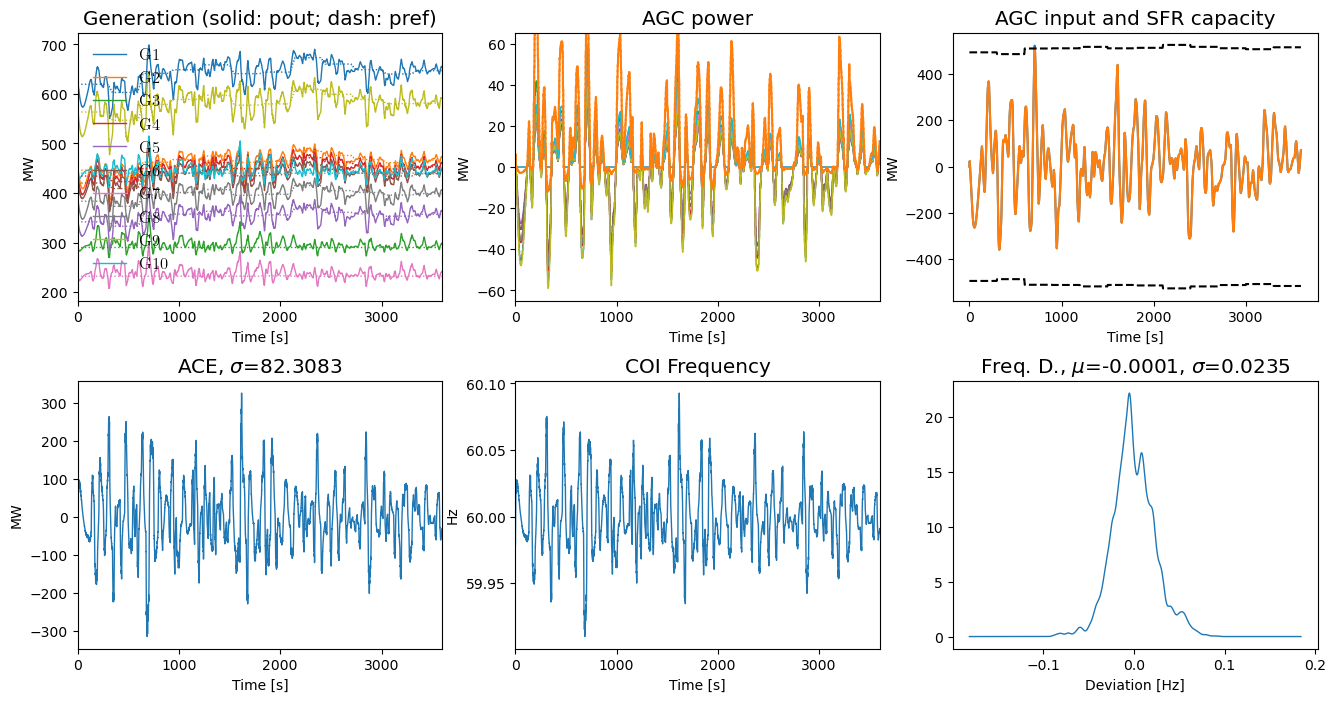

In [17]:
%run -i 'cosim_plot.py'

/tmp/ipykernel_3227662/3591543715.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{np.round(i*100,0)}\%' for i in np.arange(0, 1.1, 0.2)])


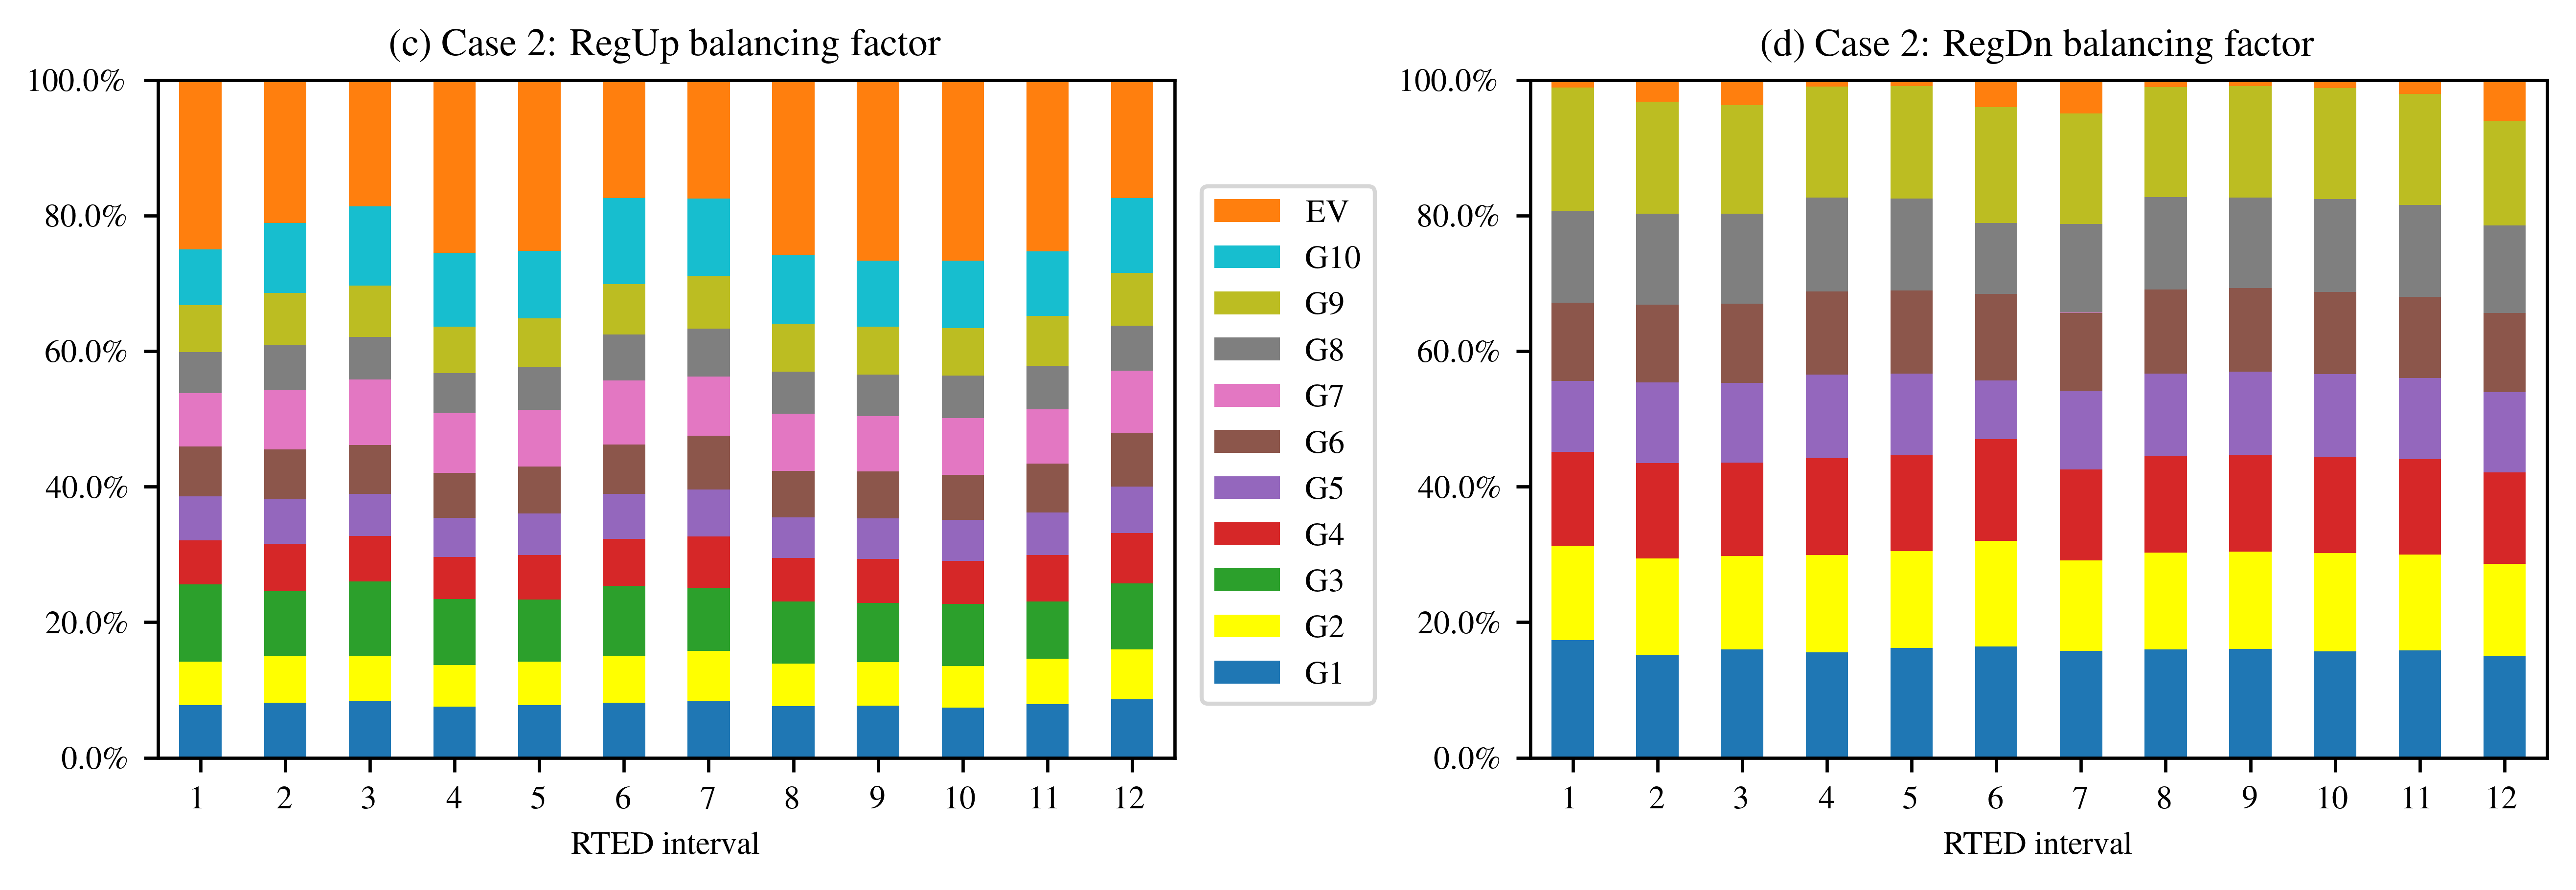

In [18]:
import matplotlib.font_manager
plt.style.use('ieee')

color = ['tab:blue', 'yellow', 'tab:green',
         'tab:red', 'tab:purple', 'tab:brown',
         'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'tab:orange']

figs, axes = plt.subplots(1, 2, figsize=(10.5, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.35, hspace=None)
new_cols = ['PV_1', 'PV_2', 'PV_3', 'PV_4', 'PV_5', 'PV_6',
            'PV_7', 'PV_8', 'PV_9', 'Slack_10', 'PV_10']
bu_df[new_cols].plot.bar(stacked=True, ax=axes[0], legend=False, color=color)
bd_df[new_cols].plot.bar(stacked=True, ax=axes[1], legend=False, color=color)

# TODO: color, label
for ax in axes:
    ax.tick_params(axis='x', labelrotation = 0)
    ax.set_ylim([0, 1])
    ax.set_yticklabels([f'{np.round(i*100,0)}\%' for i in np.arange(0, 1.1, 0.2)])
    ax.set_xticklabels([i for i in range(1,13,1)])
    ax.set_xlabel('RTED interval')
axes[0].set_title('(c) Case 2: RegUp balancing factor')
axes[1].set_title('(d) Case 2: RegDn balancing factor')
lines_labels = [ax.get_legend_handles_labels() for ax in axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
line_plot = lines[0:11]
line_plot.reverse()
label_g = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'EV']
label_g.reverse()
figs.legend(line_plot, label_g, loc='center')

In [14]:
cosim_out.to_csv('cosim_out_F.csv')

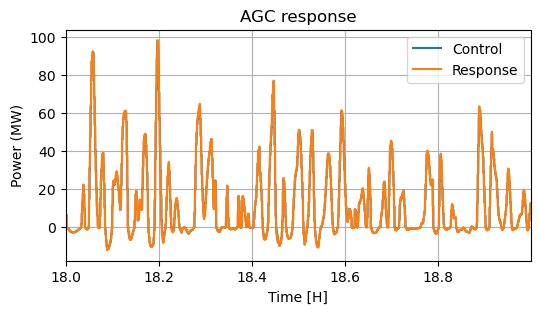

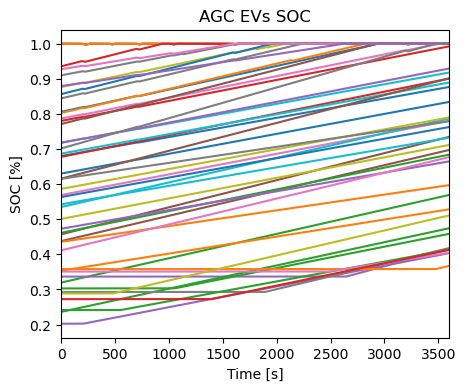

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


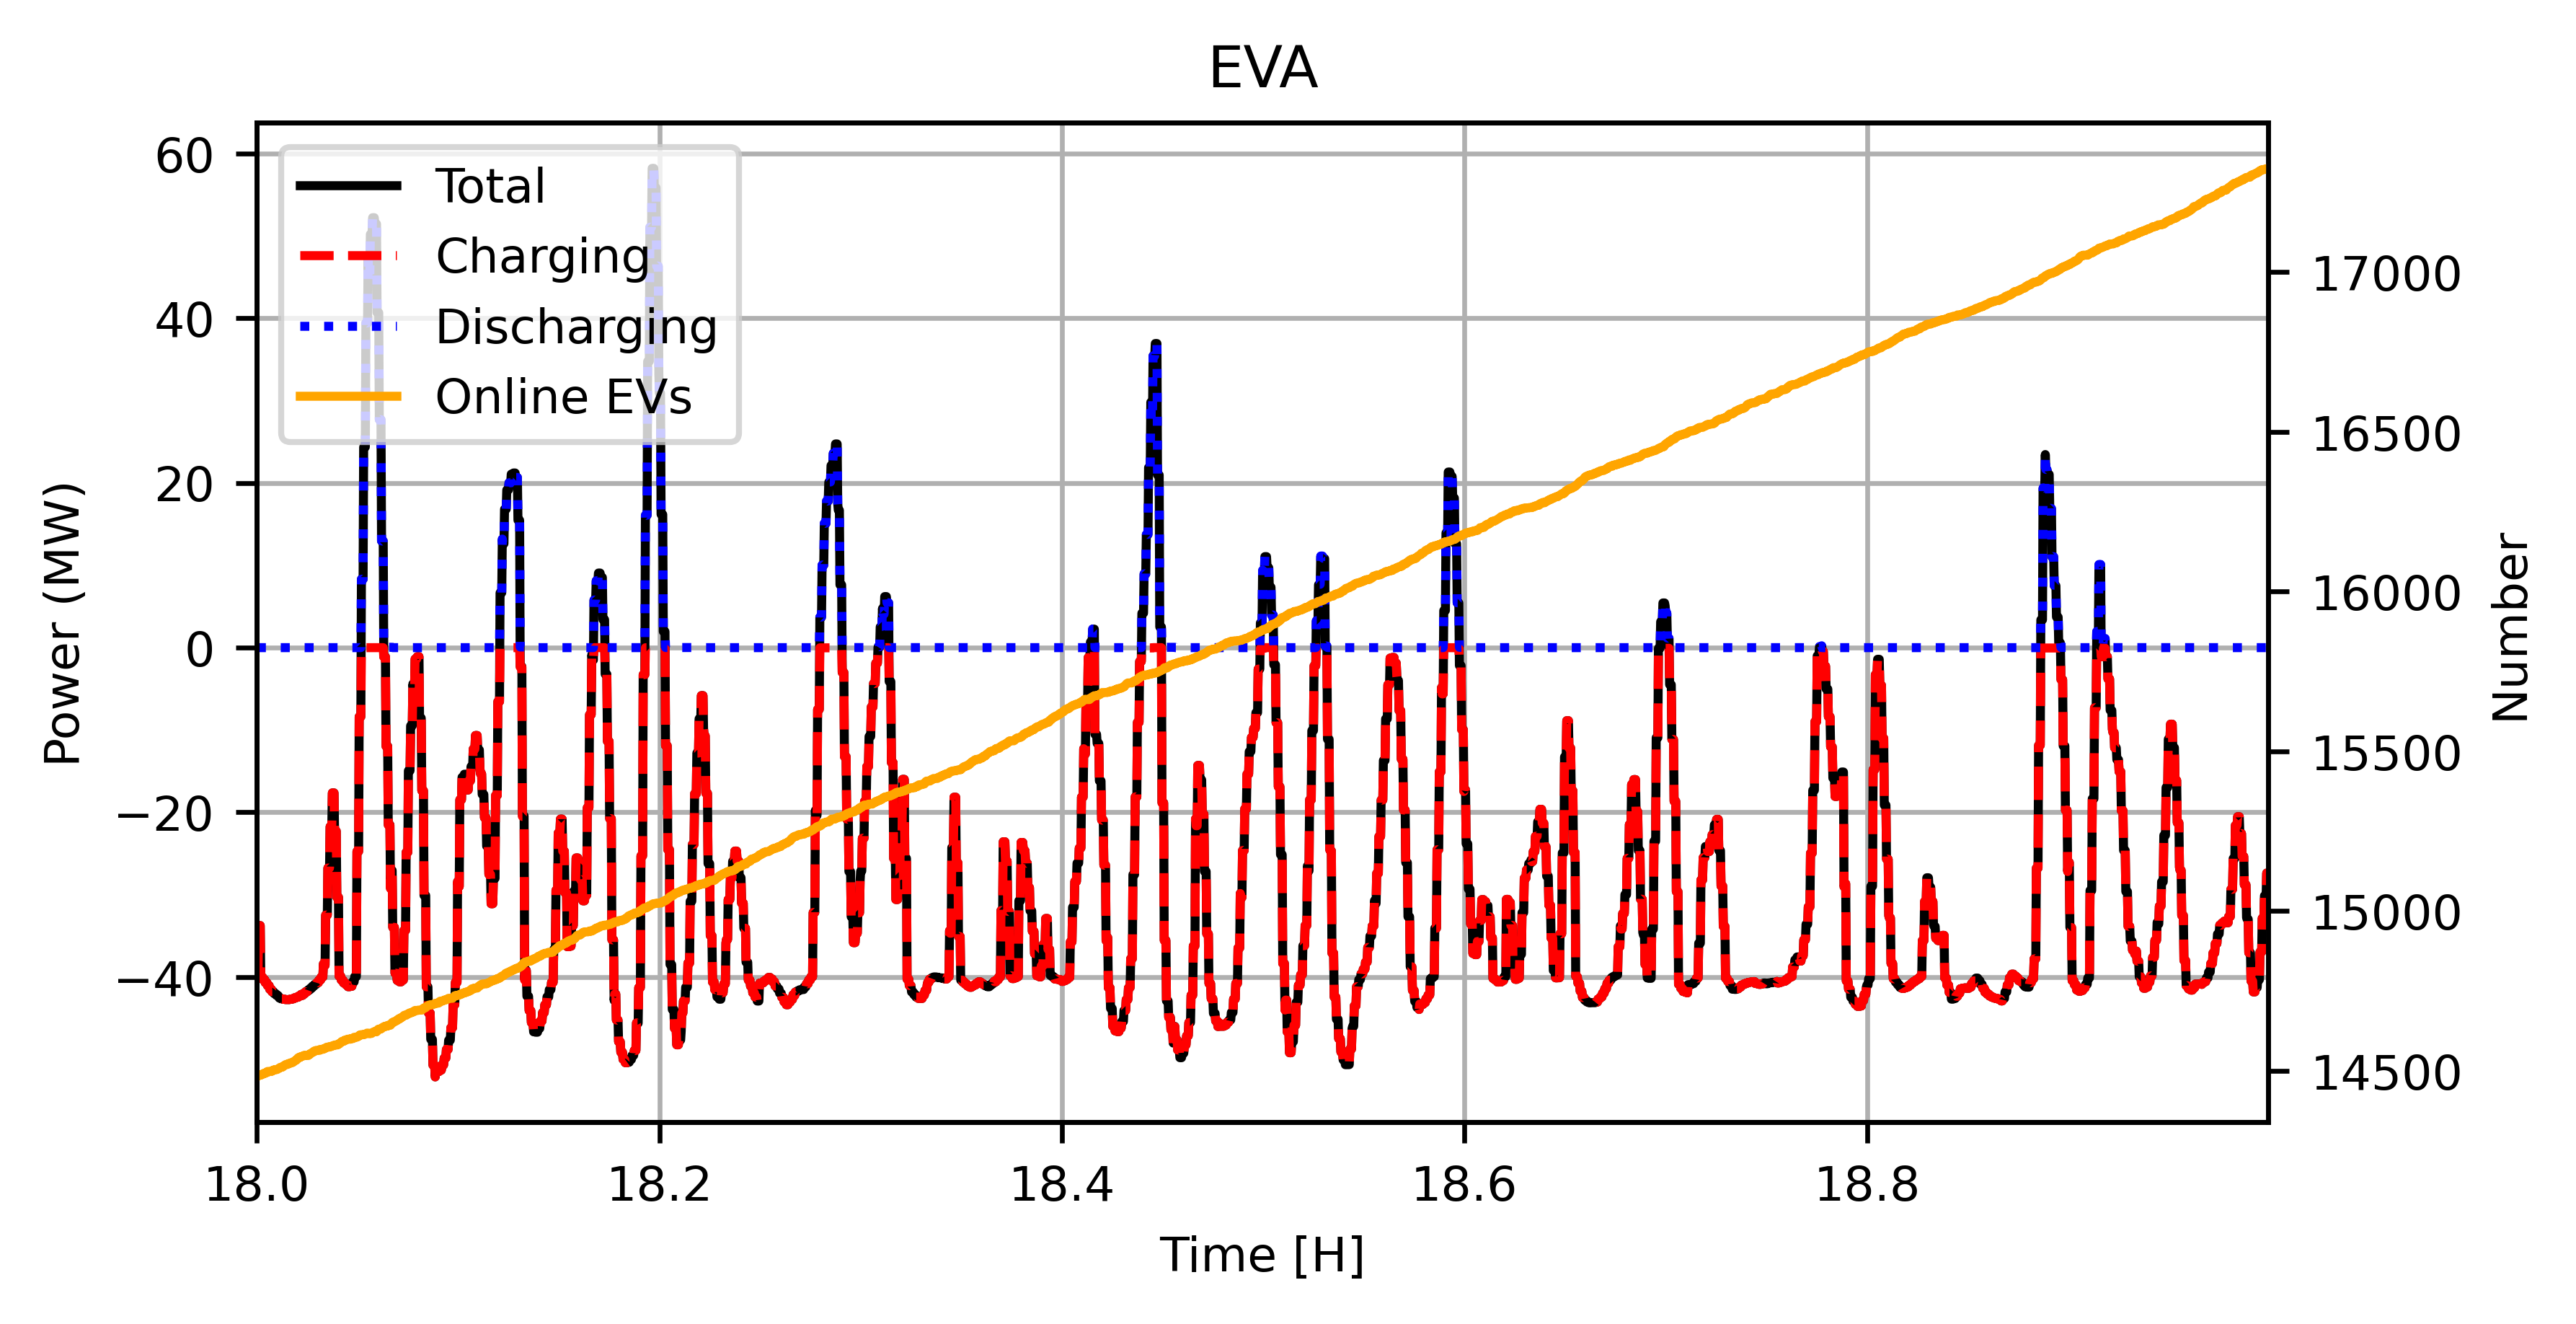

In [12]:
%run -i 'cosim_plotev.py'